<a href="https://colab.research.google.com/github/elmahygurl/NLP_sst_Classification/blob/main/NLP_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting dataset

In [117]:
!pip install datasets

In [118]:
from datasets import load_dataset, Dataset


In [119]:
sst_dataset = load_dataset('sst')

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for sst contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sst
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [120]:
print(sst_dataset['train'][500])
print(f"Number of training examples: {len(sst_dataset['train'])}")
print(f"Number of validation examples: {len(sst_dataset['validation'])}")
print(f"Number of test examples: {len(sst_dataset['test'])}")

{'sentence': 'This story still seems timely and important .', 'label': 0.6944400072097778, 'tokens': 'This|story|still|seems|timely|and|important|.', 'tree': '14|14|13|11|9|9|10|12|10|11|12|13|15|15|0'}
Number of training examples: 8544
Number of validation examples: 1101
Number of test examples: 2210


# Preprocessing

Removing the 'tree' column and adjusting the labels to accomodate the 5 classes we want to classify to where:
From 0 to 0.2 (0.2 included) will be class 0 “very negative”.

From 0.2 to 0.4 (0.4 included) will be class 1 “negative”.

From 0.4 to 0.6 (0.6 included) will be class 2 “neutral”.

From 0.6 to 0.8 (0.8 included) will be class 3 “positive”.

From 0.8 to 1.0 (1.0 included) will be class 4 “very positive”.

In [121]:
#converting splits to Pandas DataFrame for manipulation
import pandas as pd
train_df = pd.DataFrame(sst_dataset['train'])
test_df = pd.DataFrame(sst_dataset['test'])
val_df = pd.DataFrame(sst_dataset['validation'])

#function to map float labels to our desired categorical classes
def map_labels_to_categories(label):
    if 0.0 <= label <= 0.2:
        return 0  # very negative
    elif 0.2 < label <= 0.4:
        return 1  # negative
    elif 0.4 < label <= 0.6:
        return 2  # neutral
    elif 0.6 < label <= 0.8:
        return 3  # positive
    elif 0.8 < label <= 1.0:
        return 4  # very positive

#mapping function to create a new column with mapped labels
train_df['mapped_label'] = train_df['label'].apply(map_labels_to_categories)
test_df['mapped_label'] = test_df['label'].apply(map_labels_to_categories)
val_df['mapped_label'] = val_df['label'].apply(map_labels_to_categories)

#dropping the original label column
train_df = train_df.drop('label', axis=1)
test_df = test_df.drop('label', axis=1)
val_df = val_df.drop('label', axis=1)

train_df = train_df.drop(columns=['tree']) #dropping 'tree' column
test_df = test_df.drop(columns=['tree'])
val_df = val_df.drop(columns=['tree'])

######just to print an output and visualise
#convert the DataFrame back to the datasets format
sst_dataset['train'] = Dataset.from_pandas(train_df)
sst_dataset['test'] = Dataset.from_pandas(test_df)
sst_dataset['validation'] = Dataset.from_pandas(val_df)

#display the updated dataset
print(sst_dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'tokens', 'mapped_label'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['sentence', 'tokens', 'mapped_label'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['sentence', 'tokens', 'mapped_label'],
        num_rows: 2210
    })
})


In [122]:
#analyzing the distribution of labels
train_label_distribution = train_df['mapped_label'].value_counts().sort_index()
test_label_distribution = test_df['mapped_label'].value_counts().sort_index()
val_label_distribution = val_df['mapped_label'].value_counts().sort_index()

print("Training Split Label Distribution:")
print(train_label_distribution)

print("\nTest Split Label Distribution:")
print(test_label_distribution)

print("\nValidation Split Label Distribution:")
print(val_label_distribution)


Training Split Label Distribution:
0    1092
1    2218
2    1624
3    2322
4    1288
Name: mapped_label, dtype: int64

Test Split Label Distribution:
0    279
1    633
2    389
3    510
4    399
Name: mapped_label, dtype: int64

Validation Split Label Distribution:
0    139
1    289
2    229
3    279
4    165
Name: mapped_label, dtype: int64


### Visualisation for us

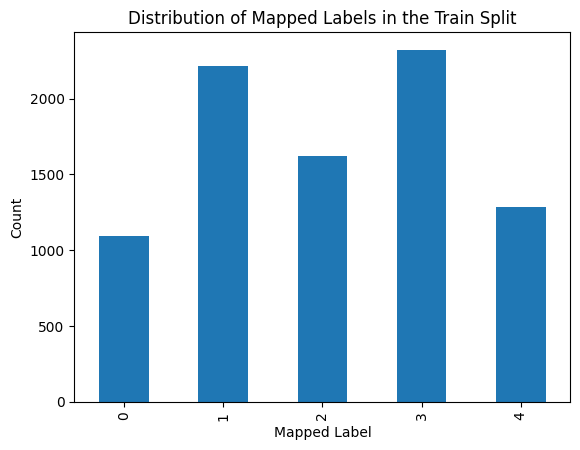

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
train_df = pd.DataFrame(sst_dataset['train']) #convert the 'train' split to a Pandas DataFrame

# Plot the distribution of mapped labels in the 'train' split
train_df['mapped_label'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Mapped Labels in the Train Split')
plt.xlabel('Mapped Label')
plt.ylabel('Count')
plt.show()

In [ ]:
#print first few rows of the 'train' split to see the transformed data
print(train_df.head())

#to ensure correct mapping
print("Unique values in mapped_labels = ",train_df['mapped_label'].unique())

#check for missing values in the 'mapped_label' column of the 'train' split
print("Missing = ",train_df['mapped_label'].isnull().sum())


                                            sentence  \
0  The Rock is destined to be the 21st Century 's...   
1  The gorgeously elaborate continuation of `` Th...   
2  Singer\/composer Bryan Adams contributes a sle...   
3  You 'd think by now America would have had eno...   
4               Yet the act is still charming here .   

                                              tokens  mapped_label  
0  The|Rock|is|destined|to|be|the|21st|Century|'s...             3  
1  The|gorgeously|elaborate|continuation|of|``|Th...             4  
2  Singer\/composer|Bryan|Adams|contributes|a|sle...             3  
3  You|'d|think|by|now|America|would|have|had|eno...             2  
4               Yet|the|act|is|still|charming|here|.             3  
Unique values in mapped_labels =  [3 4 2 1 0]
Missing =  0


## Naive Bayes


In [ ]:
import numpy as np
def train_naive_bayes(D, C):
    Ndoc = len(D)   #total number of documents in training dataset D
    Nc = np.array([np.sum(D['mapped_label'] == c) for c in C]) #calculates no. of documents in D that belong to each class in C
    logprior = np.log(Nc / Ndoc) #calculating prior probability of each class

    #building vocabulary of D
    V = set()
    for doc in D['sentence']:
        V.update(doc.split())  #adding to V so it has unique words
    V = list(V) #converting to list

    #calculating P(w|c) terms
    bigdoc = {}  #new dictionary
    for c in C:
        bigdoc[c] = ' '.join(D[D['mapped_label'] == c]['sentence']).split() #concatenate sentences of documents belonging to each class and split them into words

    #calculating frequency of each word in vocabulary for each class and store counts in a 2D NumPy array count
    count = np.zeros((len(V), len(C)))
    for i, word in enumerate(V):
        for j, c in enumerate(C):
            count[i, j] = bigdoc[c].count(word)

    #calculate log likelihoods of each word given each class
    #using Laplace smoothing to avoid zero probabilities
    loglikelihood = np.log((count + 1) / (np.sum(count, axis=0, keepdims=True) + len(V)))

    return logprior, loglikelihood, V

def test_naive_bayes(testdoc, logprior, loglikelihood, C, V):
    sum_ = np.zeros(len(C))  # to store log probabilities of each class for the given testdoc
    for c in C:
        sum_[c] = logprior[c]
        for word in testdoc.split():
            if word in V:  #if present in vocab
                sum_[c] += loglikelihood[V.index(word), c]

    return np.argmax(sum_) #returns index of the class with the highest log probability (indicating predicted class for the testdoc)

#list with the classes we have (aka labels)
C = [0, 1, 2, 3, 4]

#Trainingg
logprior, loglikelihood, V = train_naive_bayes(train_df, C)

#Testingg
correct = 0
total = len(test_df)
for i in range(total):
    predicted_label = test_naive_bayes(test_df.iloc[i]['sentence'], logprior, loglikelihood, C, V)
    if predicted_label == test_df.iloc[i]['mapped_label']:
        correct += 1

accuracy = correct / total
print("Accuracy when splitting sentence:", accuracy)


Accuracy when splitting sentence: 0.39683257918552034


#####same thing but with existing tokens in dataset not spliting the sentence

In [ ]:
def train_naive_bayes1(D, C):
    #calculate P(c) terms
    Ndoc = len(D)
    Nc = np.array([np.sum(D['mapped_label'] == c) for c in C])
    logprior = np.log(Nc / Ndoc)

    # building vocab with existing tokens in dataset
    V = set()
    for tokens in D['tokens']:
        V.update(tokens)
    V = list(V)

    #calculate P(w|c) terms
    bigdoc = {}
    for c in C:
        bigdoc[c] = [token for tokens in D[D['mapped_label'] == c]['tokens'] for token in tokens]

    count = np.zeros((len(V), len(C)))
    for i, word in enumerate(V):
        for j, c in enumerate(C):
            count[i, j] = bigdoc[c].count(word)

    loglikelihood = np.log((count + 1) / (np.sum(count, axis=0, keepdims=True) + len(V)))

    return logprior, loglikelihood, V

def test_naive_bayes1(testdoc, logprior, loglikelihood, C, V):
    sum_ = np.zeros(len(C))
    for c in C:
        sum_[c] = logprior[c]
        for word in testdoc:
            if word in V:
                sum_[c] += loglikelihood[V.index(word), c]

    return np.argmax(sum_)

#classes
C = [0, 1, 2, 3, 4]

logprior, loglikelihood, V = train_naive_bayes1(train_df, C)

correct = 0
total = len(test_df)
for i in range(total):
    predicted_label = test_naive_bayes1(test_df.iloc[i]['tokens'], logprior, loglikelihood, C, V)
    if predicted_label == test_df.iloc[i]['mapped_label']:
        correct += 1

accuracy = correct / total
print("Accuracy with existing tokens in dataset:", accuracy)


Accuracy with existing tokens in dataset: 0.2864253393665158


####Metrics and comparison with sklearn

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

#create pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB(alpha=1.0))  # Alpha parameter for Laplace smoothing
    ])

#Train pipeline
pipeline.fit(train_df['sentence'], train_df['mapped_label'])


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [ ]:
# Make predictions
predictions_sklearn = pipeline.predict(test_df['sentence'])

accuracy_sklearn = accuracy_score(test_df['mapped_label'], predictions_sklearn)
print("Accuracy (scikit-learn):", accuracy_sklearn)


Accuracy (scikit-learn): 0.4090497737556561


In [ ]:
#  function to make the Confusion Matrix
def confusion_matrix_numpy(y_true, y_pred, num_classes):
    confusion_mat = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        confusion_mat[true][pred] += 1
    return confusion_mat

conf_matrix_numpy = confusion_matrix_numpy(test_df['mapped_label'], predictions_sklearn, len(C))
print("Confusion Matrix (only using numpy):\n", conf_matrix_numpy)

# Precision, Recall, and F1 score per class
def precision_recall_f1_numpy(conf_matrix):
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

precision_numpy, recall_numpy, f1_numpy = precision_recall_f1_numpy(conf_matrix_numpy)
print("Precision:", precision_numpy)
print("Recall:", recall_numpy)
print("F1 Score:", f1_numpy)

# Macro-averaged Precision, Recall, and F1 score
def macro_averaged_metrics_numpy(precision, recall, f1):
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    return macro_precision, macro_recall, macro_f1

precision_macro_numpy, recall_macro_numpy, f1_macro_numpy = macro_averaged_metrics_numpy(precision_numpy, recall_numpy, f1_numpy)
print("Macro-averaged Precision:", precision_macro_numpy)
print("Macro-averaged Recall:", recall_macro_numpy)
print("Macro-averaged F1 Score:", f1_macro_numpy)


Confusion Matrix (only using numpy):
 [[ 28 200  10  41   0]
 [ 22 415  57 127  12]
 [  8 154  34 181  12]
 [  2  88  39 340  41]
 [  2  39  12 259  87]]
Precision: [0.4516129  0.46316964 0.22368421 0.35864979 0.57236842]
Recall: [0.10035842 0.65560821 0.0874036  0.66666667 0.21804511]
F1 Score: [0.16422287 0.54283846 0.12569316 0.46639232 0.31578947]
Macro-averaged Precision: 0.41389699333828645
Macro-averaged Recall: 0.3456164032418666
Macro-averaged F1 Score: 0.3229872566299008


##### better representation (for us)

In [ ]:
import pandas as pd

#create DataFrame for precision, recall, and F1 score
metrics_df = pd.DataFrame({
    'Precision': precision_numpy,
    'Recall': recall_numpy,
    'F1 Score': f1_numpy
}, index=C)  # Assuming C contains the class labels


# create DataFrame for macro-averaged precision, recall, and F1 score
macro_metrics_df = pd.DataFrame({
    'Precision': [precision_macro_numpy],
    'Recall': [recall_macro_numpy],
    'F1 Score': [f1_macro_numpy]
})

print("Metrics per class (scikit-learn):\n", metrics_df)
print("-------------------------------------")
print("Macro-averaged Metrics (scikit-learn):\n", macro_metrics_df)


Metrics per class (scikit-learn):
    Precision    Recall  F1 Score
0   0.451613  0.100358  0.164223
1   0.463170  0.655608  0.542838
2   0.223684  0.087404  0.125693
3   0.358650  0.666667  0.466392
4   0.572368  0.218045  0.315789
-------------------------------------
Macro-averaged Metrics (scikit-learn):
    Precision    Recall  F1 Score
0   0.413897  0.345616  0.322987


# Logistic regression

In [ ]:
import numpy as np

# Assume train_data is your Dataset object containing 'sentence', 'tokens', and 'mapped_label'

# Step 1: Preprocessing
sentences = train_data['sentence']
tokens = train_data['tokens']
mapped_labels = train_data['mapped_label']

word_bi_grams = []
for sentence_tokens in tokens:
    bi_grams = [(sentence_tokens[i], sentence_tokens[i + 1]) for i in range(len(sentence_tokens) - 1)]
    word_bi_grams.extend(bi_grams)


vocab = list(set(word_bi_grams))
vocab_size = len(vocab)



In [ ]:
# Step 2: Feature Representation
def create_feature_vector(sentence_tokens, vocab):
    feature_vector = np.zeros(len(vocab))
    for i in range(len(sentence_tokens) - 1):
        bi_gram = (sentence_tokens[i], sentence_tokens[i + 1])
        if bi_gram in vocab:
            feature_vector[vocab.index(bi_gram)] = 1
    return feature_vector

X_train = np.array([create_feature_vector(tokens[i], vocab) for i in range(len(tokens))])
y_train = np.array(mapped_labels)

BiGramClass:

```
 we implimented the three steps in one class to help us during the testing phase
```



In [8]:
import numpy as np
train_dataset = sst_dataset['train']
class BiGramLogisticRegression:

    def __init__(self, learning_rate=0.001, num_epochs=100):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.vocab = None
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def initialize_params(self, num_features):
        self.weights = np.random.randn(num_features)
        self.bias = 0

    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-10
        return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))


#the preprocessing bi-gram set
    def preprocess_and_create_vocab(self, data):
        sentences = data['sentence']
        tokens = data['tokens']

        word_bi_grams = []
        for sentence_tokens in tokens:
            bi_grams = [(sentence_tokens[i], sentence_tokens[i + 1]) for i in range(len(sentence_tokens) - 1)]
            word_bi_grams.extend(bi_grams)

        self.vocab = list(set(word_bi_grams))

#creating a vector of 1 if bigram exists in dataset else 0
    def create_feature_vector(self, sentence_tokens):
        feature_vector = np.zeros(len(self.vocab))
        for i in range(len(sentence_tokens) - 1):
            bi_gram = (sentence_tokens[i], sentence_tokens[i + 1])
            if bi_gram in self.vocab:
                feature_vector[self.vocab.index(bi_gram)] = 1
        return feature_vector

    def fit(self, data):
        self.preprocess_and_create_vocab(data)
        X_train = np.array([self.create_feature_vector(tokens) for tokens in data['tokens']])
        y_train = np.array(data['mapped_label'])

        num_samples, num_features = X_train.shape
        self.initialize_params(num_features)

        for epoch in range(self.num_epochs):
            # Forward pass
            logits = np.dot(X_train, self.weights) + self.bias
            y_pred = self.sigmoid(logits)

            # Compute loss
            loss = self.compute_loss(y_train, y_pred)

            # Compute gradients
            dw = (1 / num_samples) * np.dot(X_train.T, (y_pred - y_train))
            db = (1 / num_samples) * np.sum(y_pred - y_train)

            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, data):
        X_test = np.array([self.create_feature_vector(tokens) for tokens in data['tokens']])
        logits = np.dot(X_test, self.weights) + self.bias
        y_pred = self.sigmoid(logits)

        # Define class boundaries
        thresholds = [0.2, 0.4, 0.6, 0.8]

        # Classify based on thresholds
        predictions = np.zeros(len(y_pred), dtype=int)
        for i, pred in enumerate(y_pred):
            if pred < thresholds[0]:
                predictions[i] = 0
            elif pred < thresholds[1]:
                predictions[i] = 1
            elif pred < thresholds[2]:
                predictions[i] = 2
            elif pred < thresholds[3]:
                predictions[i] = 3
            else:
                predictions[i] = 4  # For values >= 0.8
        return predictions

# Initialize the logistic regression model
model = BiGramLogisticRegression()

# Train the model on the training data
model.fit(train_dataset)

Epoch 0, Loss: 12.950020654120213
Epoch 10, Loss: 12.031308075029264
Epoch 20, Loss: 11.130034776300405
Epoch 30, Loss: 10.2476306078688
Epoch 40, Loss: 9.385346623719448
Epoch 50, Loss: 8.544243369480888
Epoch 60, Loss: 7.725147219465302
Epoch 70, Loss: 6.928662171945825
Epoch 80, Loss: 6.155199294865913
Epoch 90, Loss: 5.404974801265081


In [9]:

test_predictions= model.predict(sst_dataset['test'])

In [11]:
def confusion_matrix(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    matrix = np.zeros((num_classes, num_classes))

    for i in range(len(y_true)):
        true_label = y_true[i]
        predicted_label = y_pred[i]
        matrix[true_label][predicted_label] += 1

    return matrix



conf_matrix = confusion_matrix(sst_dataset['test']['mapped_label'], test_predictions)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[151.  16.  23.  13.  76.]
 [321.  44.  38.  32. 198.]
 [195.  22.  19.  20. 133.]
 [251.  37.  29.  32. 161.]
 [222.  25.  23.  18. 111.]]


In [12]:
def precision(conf_matrix):
    true_positives = np.diag(conf_matrix)
    false_positives = np.sum(conf_matrix, axis=0) - true_positives
    with np.errstate(divide='ignore', invalid='ignore'):
        precision_values = true_positives / (true_positives + false_positives)
        precision_values[np.isnan(precision_values)] = 0  # Replace NaN values with zero
    return precision_values

def recall(conf_matrix):
    true_positives = np.diag(conf_matrix)
    false_negatives = np.sum(conf_matrix, axis=1) - true_positives
    return true_positives / (true_positives + false_negatives)

def accuracy(conf_matrix):
    correct_predictions = np.sum(np.diag(conf_matrix))
    total_predictions = np.sum(conf_matrix)
    return correct_predictions / total_predictions

def f1_score(precision, recall):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_values = 2 * (precision * recall) / (precision + recall)
        f1_values[np.isnan(f1_values)] = 0  # Replace NaN values with zero
    return f1_values



precisions = precision(conf_matrix)
recalls = recall(conf_matrix)
accur = accuracy(conf_matrix)
f1_scores = f1_score(precisions, recalls)
print("\nPrecision:", precisions)
print("Recall:", recalls)
print("Accuracy:", accur)
print("F1 Score:", f1_scores)


Precision: [0.13245614 0.30555556 0.14393939 0.27826087 0.1634757 ]
Recall: [0.54121864 0.06951027 0.04884319 0.0627451  0.27819549]
Accuracy: 0.16153846153846155
F1 Score: [0.21282593 0.11325611 0.07293666 0.1024     0.20593692]


**SKLEARN**

---






In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
test_data=sst_dataset['test']
# Preprocess the text data
vectorizer = CountVectorizer(ngram_range=(2, 2))  # Using word bi-grams
X_train_vectorized = vectorizer.fit_transform(train_dataset['sentence'])
X_test_vectorized = vectorizer.transform(test_data['sentence'])

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vectorized, train_dataset['mapped_label'])

# Predict labels for the test dataset
y_pred = model.predict(X_test_vectorized)

# Evaluate the model
conf_matrix = confusion_matrix(test_data['mapped_label'], y_pred)
accuracy = accuracy_score(test_data['mapped_label'], y_pred)
precision = precision_score(test_data['mapped_label'], y_pred, average=None)
recall = recall_score(test_data['mapped_label'], y_pred, average=None)
f1 = f1_score(test_data['mapped_label'], y_pred, average=None)

# Print results
print("Confusion Matrix:")
print(conf_matrix)
print("\nPrecision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1)


Confusion Matrix:
[[ 36 136  41  58   8]
 [ 38 332  97 148  18]
 [ 18 152  57 142  20]
 [  4 142  49 274  41]
 [ 11  77  35 192  84]]

Precision: [0.3364486  0.39570918 0.20430108 0.33660934 0.49122807]
Recall: [0.12903226 0.52448657 0.14652956 0.5372549  0.21052632]
Accuracy: 0.35429864253393667
F1 Score: [0.1865285  0.45108696 0.17065868 0.41389728 0.29473684]


SECOND TRY:

In [165]:
import numpy as np

class BiGramVectorizer:
    def __init__(self):
        self.bi_gram_index = {}
        self.vocab_size = 0

    def fit_transform(self, sentences):
        bi_grams = []
        for sentence in sentences:
            tokens = sentence.split('|')
            bi_grams.extend([(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)])
        unique_bi_grams = list(set(bi_grams))
        self.vocab_size = len(unique_bi_grams)
        self.bi_gram_index = {bi_gram: i for i, bi_gram in enumerate(unique_bi_grams)}
        print(bi_grams)

        features = np.zeros((len(sentences), self.vocab_size), dtype=np.int16)
        for i, sentence in enumerate(sentences):
            tokens = sentence.split('|')
            for j in range(len(tokens)-1):
                bi_gram = (tokens[j], tokens[j+1])
                if bi_gram in self.bi_gram_index:
                    features[i, self.bi_gram_index[bi_gram]] = 1
        return features

    def transform(self, sentences):
        # Generate feature matrix using existing vocabulary
        features = np.zeros((len(sentences), self.vocab_size), dtype=np.int16)
        for i, sentence in enumerate(sentences):
            tokens = sentence.split('|')
            for j in range(len(tokens)-1):
                bi_gram = (tokens[j], tokens[j+1])
                if bi_gram in self.bi_gram_index:
                    features[i, self.bi_gram_index[bi_gram]] = 1
        return features

# Example usage:
sentences = sst_dataset['train']['tokens']

vectorizer = BiGramVectorizer()
X_train = vectorizer.fit_transform(sentences)
print(X_train)


[('The', 'Rock'), ('Rock', 'is'), ('is', 'destined'), ('destined', 'to'), ('to', 'be'), ('be', 'the'), ('the', '21st'), ('21st', 'Century'), ('Century', "'s"), ("'s", 'new'), ('new', '``'), ('``', 'Conan'), ('Conan', "''"), ("''", 'and'), ('and', 'that'), ('that', 'he'), ('he', "'s"), ("'s", 'going'), ('going', 'to'), ('to', 'make'), ('make', 'a'), ('a', 'splash'), ('splash', 'even'), ('even', 'greater'), ('greater', 'than'), ('than', 'Arnold'), ('Arnold', 'Schwarzenegger'), ('Schwarzenegger', ','), (',', 'Jean-Claud'), ('Jean-Claud', 'Van'), ('Van', 'Damme'), ('Damme', 'or'), ('or', 'Steven'), ('Steven', 'Segal'), ('Segal', '.'), ('The', 'gorgeously'), ('gorgeously', 'elaborate'), ('elaborate', 'continuation'), ('continuation', 'of'), ('of', '``'), ('``', 'The'), ('The', 'Lord'), ('Lord', 'of'), ('of', 'the'), ('the', 'Rings'), ('Rings', "''"), ("''", 'trilogy'), ('trilogy', 'is'), ('is', 'so'), ('so', 'huge'), ('huge', 'that'), ('that', 'a'), ('a', 'column'), ('column', 'of'), ('of',

In [140]:
matrix_sum = np.sum(X_train)

# Print the sum
print("Sum of matrix elements:", matrix_sum)


Sum of matrix elements: 154332


In [225]:
import numpy as np

class LogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=10, batch_size=3200):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = None
        self.bias = None

    def softmax(self, z):
        exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, y, y_pred):
        num_samples = y.shape[0]
        loss = -np.sum(y * np.log(y_pred)) / num_samples
        return loss

    def fit(self, X, y):
        num_classes = 5
        num_samples, num_features = X.shape

        # Initialize weights and biases
        self.weights = np.zeros((num_features, num_classes))
        self.bias = np.zeros(num_classes)

        # One-hot encode the labels
        one_hot_y = np.eye(num_classes)[y]

        # Training loop
        for epoch in range(self.epochs):
            logits = np.dot(X_train, self.weights) + self.bias
            y_pred = self.sigmoid(logits)

            # Forward pass
            z = np.dot(X, self.weights) + self.bias
            A = self.sigmoid(z)

            # Backward pass
            dw = np.dot(X.T, (A - one_hot_y)) / num_samples
            db = np.sum(A - one_hot_y, axis=0) / num_samples

            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        probabilities = self.softmax(z)
        return np.argmax(probabilities, axis=1)


# Example usage:
labels = sst_dataset['train']['mapped_label']  # Assuming multiclass labels

# Step 2: Logistic Regression
lr_model = LogisticRegression(learning_rate=0.01, epochs=1)
lr_model.fit(X_train, labels)




In [226]:
X_test = vectorizer.transform(sst_dataset['test']['tokens'])  # Use transform instead of fit_transform for test data
test_predictions = lr_model.predict(X_train)
print( test_predictions)


[3 3 3 ... 3 3 3]


In [167]:
print(X_train.shape)
print("************************")
print(X_test.shape)

(8544, 87247)
************************
(2210, 87247)


In [227]:


def accuracy(true_labels, predicted_labels):
    correct = np.sum(true_labels == predicted_labels)
    total = len(true_labels)
    return correct / total

# Example usage:
true_labels = sst_dataset['train']['mapped_label']
predicted_labels = test_predictions

num_classes = 5


acc = accuracy(true_labels, predicted_labels)
print("Accuracy:", acc)


Accuracy: 0.2723548689138577


In [209]:
print(true_labels)

[3, 4, 3, 2, 3, 4, 4, 3, 4, 3, 4, 2, 4, 2, 4, 3, 3, 2, 4, 3, 4, 3, 2, 4, 2, 2, 4, 3, 4, 1, 4, 3, 2, 3, 4, 3, 3, 3, 2, 3, 3, 4, 2, 3, 2, 0, 3, 3, 1, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 3, 2, 3, 3, 3, 1, 1, 4, 3, 4, 4, 3, 2, 1, 3, 2, 2, 3, 4, 4, 4, 4, 3, 2, 4, 3, 3, 4, 4, 3, 4, 3, 3, 1, 4, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 2, 3, 2, 3, 3, 3, 4, 1, 2, 2, 2, 4, 3, 3, 3, 3, 2, 4, 4, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 4, 4, 3, 3, 4, 2, 4, 3, 2, 1, 3, 2, 3, 3, 1, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 4, 3, 1, 2, 4, 3, 3, 1, 3, 4, 4, 3, 3, 3, 3, 3, 1, 4, 4, 2, 4, 3, 3, 3, 3, 4, 3, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 2, 4, 2, 3, 4, 2, 4, 3, 1, 2, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 4, 3, 3, 4, 4, 3, 3, 4, 3, 3, 2, 4, 2, 3, 4, 2, 2, 4, 3, 3, 2, 3, 4, 3, 3, 4, 3, 4, 3, 3, 2, 4, 1, 4, 4, 3, 3, 4, 3, 3, 4, 4, 3, 3, 2, 4, 4, 3, 2, 1, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 2, 1, 3, 2, 4, 4, 3, 4, 3, 3, 

In [228]:
import numpy as np

def confusion_matrix(true_labels, predicted_labels, num_classes):
    conf_mat = np.zeros((num_classes, num_classes))
    for true, pred in zip(true_labels, predicted_labels):
        conf_mat[true, pred] += 1
    return conf_mat

def precision_recall_f1(conf_mat):
    num_classes = conf_mat.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    for i in range(num_classes):
        tp = conf_mat[i, i]
        fp = np.sum(conf_mat[:, i]) - tp
        fn = np.sum(conf_mat[i, :]) - tp
        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
    return precision, recall, f1

def macro_average(metric):
    return np.mean(metric)



num_classes = 5
conf_mat = confusion_matrix(true_labels, predicted_labels, num_classes)
print("Confusion Matrix:")
print(conf_mat)

precision, recall, f1 = precision_recall_f1(conf_mat)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1 score per class:", f1)

macro_precision = macro_average(precision)
macro_recall = macro_average(recall)
macro_f1 = macro_average(f1)
print("Macro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1 score:", macro_f1)


Confusion Matrix:
[[   0.    0.    0. 1092.    0.]
 [   0.    5.    0. 2213.    0.]
 [   0.    0.    0. 1624.    0.]
 [   0.    0.    0. 2322.    0.]
 [   0.    0.    0. 1288.    0.]]
Precision per class: [0.        1.        0.        0.2719288 0.       ]
Recall per class: [0.         0.00225428 0.         1.         0.        ]
F1 score per class: [0.         0.00449843 0.         0.42758494 0.        ]
Macro-averaged Precision: 0.25438575945661085
Macro-averaged Recall: 0.20045085662759243
Macro-averaged F1 score: 0.08641667249627165


In [194]:
import numpy as np

def confusion_matrix(y_true, y_pred, num_classes):
    """
    Generate the confusion matrix given the predictions and the ground truth labels.

    Parameters:
    - y_true: Array of true labels.
    - y_pred: Array of predicted labels.
    - num_classes: Number of classes in the classification task.

    Returns:
    - cm: Confusion matrix.
    """
    cm = np.zeros((num_classes, num_classes), dtype=np.int32)
    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label, pred_label] += 1
    return cm

def compute_metrics(confusion_matrix):
    """
    Compute precision, recall, and F1 score per class and macro-averaged from the confusion matrix.

    Parameters:
    - confusion_matrix: Confusion matrix.

    Returns:
    - precision: Array of precision values per class.
    - recall: Array of recall values per class.
    - f1_score: Array of F1 score values per class.
    - macro_precision: Macro-averaged precision.
    - macro_recall: Macro-averaged recall.
    - macro_f1_score: Macro-averaged F1 score.
    """
    num_classes = confusion_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = np.sum(confusion_matrix[:, i]) - tp
        fn = np.sum(confusion_matrix[i, :]) - tp

        precision[i] = tp / (tp + fp) if tp + fp != 0 else 0
        recall[i] = tp / (tp + fn) if tp + fn != 0 else 0
        f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if precision[i] + recall[i] != 0 else 0

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_score)

    return precision, recall, f1_score, macro_precision, macro_recall, macro_f1_score


# Example usage:
# Assuming y_true and y_pred are the ground truth and predicted labels respectively

# Step 1: Generate confusion matrix
num_classes = 5  # Assuming 5 classes
cm = confusion_matrix(true_labels, predicted_labels, num_classes)
print(cm)
# Step 2: Compute metrics
precision, recall, f1_score, macro_precision, macro_recall, macro_f1_score = compute_metrics(cm)

# Print metrics
for i in range(num_classes):
    print(f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1-Score={f1_score[i]:.4f}")

print(f"Macro-averaged Precision: {macro_precision:.4f}")
print(f"Macro-averaged Recall: {macro_recall:.4f}")
print(f"Macro-averaged F1-Score: {macro_f1_score:.4f}")


[[  0  96   0 183   0]
 [  0 238   0 395   0]
 [  0  94   0 295   0]
 [  0  84   0 426   0]
 [  0  47   0 352   0]]
Class 0: Precision=0.0000, Recall=0.0000, F1-Score=0.0000
Class 1: Precision=0.4258, Recall=0.3760, F1-Score=0.3993
Class 2: Precision=0.0000, Recall=0.0000, F1-Score=0.0000
Class 3: Precision=0.2580, Recall=0.8353, F1-Score=0.3943
Class 4: Precision=0.0000, Recall=0.0000, F1-Score=0.0000
Macro-averaged Precision: 0.1368
Macro-averaged Recall: 0.2423
Macro-averaged F1-Score: 0.1587
